# Data Scientist assessment

# Question 3

In [36]:
# import libraries
import numpy as np
from numpy import log, dot, exp, shape
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
# Create data sample for testing purpose
X, y = make_classification(n_features = 4, random_state = 42)
shape(X), shape(y)

((100, 4), (100,))

In [3]:
# Split data into training set & testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
shape(X_train), shape(y_train)

((80, 4), (80,))

In [28]:
class LogisticRegression:    
    # Mean-variance normalisation 
    def standardization(self, X):
        for i in range(len(X[0])):
            X[:, i] = (X[:, i] - np.mean(X[:, i])) / np.std(X[:, i])

        return X


    # Define sigmoid, h(z) = 1/(1 + e ** -z)
    def sigmoid(self, z):
        return 1 / (1 + exp(-z))


    # Initialize starting point & adding intercept
    def initialize(self, X):
        weights = np.zeros((len(X[0]) + 1, 1))
        X = np.c_[np.ones((len(X), 1)), X]

        return weights, X

    # Fitting
    # alpha: learning rate, iter: maximum number of iteration
    def fit(self, X, y, alpha = 0.001, iter = 500):
        weights, X = self.initialize(X)

        # MLE estimation
        # Maximise log likelihood <==> minimise loss function
        # J = -ylog(h(z)) - (1 - y)log(1 - h(z)), h is sigmoid, z = wx + b
        def cost(theta):
            z = dot(X, theta)

            cost_0 = y.T.dot(log(self.sigmoid(z)))
            cost_1 = (1 - y).T.dot(log(1 - self.sigmoid(z)))

            return (-cost_0 - cost_1) / len(y)

        # Gradient Boosting for minimisation
        # Calculate gradient: Chain rule
        # dJ/dw = dJ/dh * dh/dz * dz/dw

        # X^T * (h(z) - y)
        cost_list = np.zeros(iter)
        for i in range(iter):
            weights -= alpha * dot(X.T, self.sigmoid(dot(X, weights)) - np.reshape(y, (len(y), 1)))
            cost_list[i] = cost(weights)
        
        self.weight = weights

        return cost_list


    # Prediction
    def predict(self, X):
        z = dot(self.initialize(X)[1], self.weight)
        
        ret = []
        for i in range(len(z)):
            if self.sigmoid(z[i]) > 0.5:
                ret.append(1)
            else:
                ret.append(0)
        
        return ret
    
    # f1_score metric
    def F1_score(self, y_hat, y):
        tp = tn = fp = fn = 0
        for i in range(len(y)):
            if y_hat[i] == 1 and y[i] == 1:
                tp += 1
            if y_hat[i] == 1 and y[i] == 0:
                fp += 1
            if y_hat[i] == 0 and y[i] == 1:
                fn += 1
            if y_hat[i] == 0 and y[i] == 0:
                tn += 1
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        
        return 2 * precision * recall / (precision + recall)

In [29]:
# Experiment
logistic_regression = LogisticRegression()

model = logistic_regression.fit(X_train, y_train)
y_pred = logistic_regression.predict(X_test)
y_train_pred = logistic_regression.predict(X_train)

print(logistic_regression.F1_score(y_pred, y_test))
print(logistic_regression.F1_score(y_train_pred, y_train))

1.0
0.9866666666666666


In [8]:
logistic_regression.weight

array([[ 0.08149706],
       [-0.72272216],
       [-1.13776156],
       [-1.63910142],
       [ 2.30688063]])

# Question 4

<b> We build up ROC and Precision-Recall functions based on the experiment conducted in Question 3</b>

In [16]:
# Collect weight(parameters)
print(logistic_regression.weight)
weight = logistic_regression.weight

[[ 0.08149706]
 [-0.72272216]
 [-1.13776156]
 [-1.63910142]
 [ 2.30688063]]


In [24]:
# Collect data
data = logistic_regression.initialize(X_test)[1]
shape(data)

(20, 5)

In [48]:
# build up ROC curve
def ROC_builder(X, Y, weight, threshold):
    TPR, FPR = [0] * len(threshold), [0] * len(threshold)
    z = dot(X, weight)
    
    ret = []
    for i in range(len(threshold)):
        tmp = []
        for j in range(len(z)):
            prob = logistic_regression.sigmoid(z[j])
            
            if prob >= threshold[i]:
                tmp.append(1)
            else:
                tmp.append(0)
        
        ret.append(tmp)
    
    # Calculate TPR, FPR, precision
    def metric_builder(ret, Y):
        TPR, FPR, precision = [], [], []
        for p in range(len(ret)):
            y_hat = ret[p]
            
            tp = tn = fp = fn = 0
            for q in range(len(Y)):
                if y_hat[q] == 1 and Y[q] == 1:
                    tp += 1
                if y_hat[q] == 0 and Y[q] == 1:
                    fn += 1
                if y_hat[q] == 1 and Y[q] == 0:
                    fp += 1
                if y_hat[q] == 0 and Y[q] == 0:
                    tn += 1
            
            TPR.append(tp / (tp + fn)) 
            FPR.append(fp /(fp + tn)) 
            precision.append(tp / (tp + fp) if (tp + fp) else 0) 
            
        
        return TPR, FPR, precision
    
    return metric_builder(ret, Y)

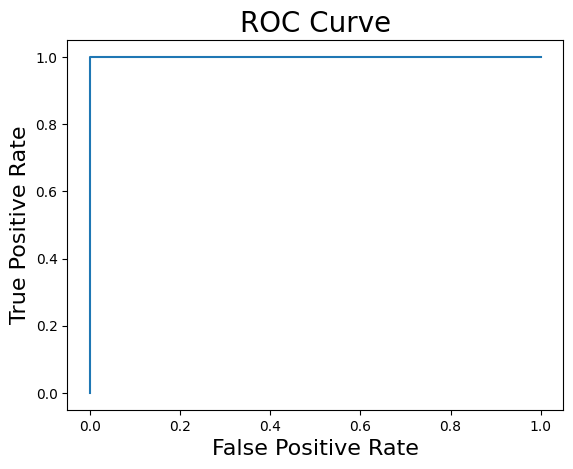

In [57]:
# We can see the classifier perform well
TPR, FPR, precision = ROC_builder(data, y_test, weight, [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0])

plt.title("ROC Curve", fontsize=20)
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.plot(FPR, TPR)

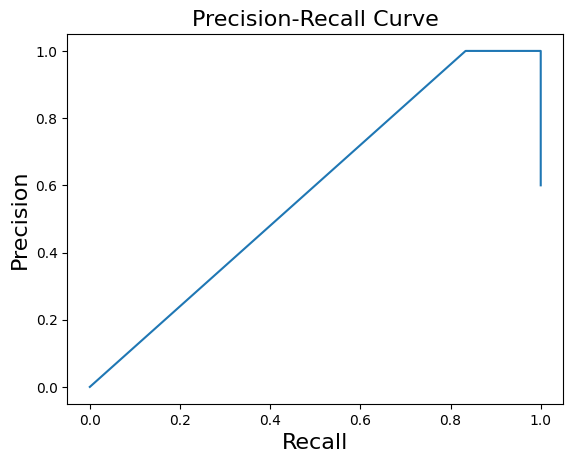

In [58]:
# Precison-Recall curve also performs well
plt.title("Precision-Recall Curve", fontsize=16)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.plot(TPR, precision)

<b> END </b>